#Import Library

In [ ]:
import os
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report
from google.colab import files
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from tensorflow.keras.applications.mobilenet_v2 import MobileNetV2
from tensorflow.keras import regularizers, models

In [ ]:
# Define paths for the dataset
base_dir = '/content/drive/MyDrive/dataset_food_classification/dataset_gambar/'
train_dir = os.path.join(base_dir, 'train')
val_dir = os.path.join(base_dir, 'valid')

#Augmentasi Data

In [ ]:
# Data augmentation for training set
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True,
    fill_mode='nearest',
)

# Validation data is only rescaled (no augmentation)
validation_datagen = ImageDataGenerator(rescale=1./255)

In [ ]:
# Generators for training, validation, and test sets
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    shuffle=True,
    seed=42
)

validation_generator = validation_datagen.flow_from_directory(
    val_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    shuffle=False,
    seed=42
)

Found 4767 images belonging to 33 classes.
Found 1456 images belonging to 33 classes.


In [ ]:
# Get class names and number of categories
class_names = train_generator.class_indices
class_names

{'Ayam Geprek': 0,
 'Ayam Goreng': 1,
 'Bakso': 2,
 'Bika Ambon': 3,
 'Bubur Ayam': 4,
 'Burger': 5,
 'Dadar Gulung': 6,
 'Gado-Gado': 7,
 'Getuk Lindri': 8,
 'Ikan Gurame Bakar': 9,
 'Ikan Mujair Bakar': 10,
 'Kentang Goreng': 11,
 'Kerak Telor': 12,
 'Klepon': 13,
 'Kue Lapis': 14,
 'Kue Sagu': 15,
 'Lemper Ayam': 16,
 'Martabak Manis': 17,
 'Mie Goreng': 18,
 'Nasi Gandul': 19,
 'Nasi Goreng': 20,
 'Nasi Kuning': 21,
 'Nasi Padang': 22,
 'Pempek': 23,
 'Pizza': 24,
 'Rawon': 25,
 'Rendang': 26,
 'Roti Bakar': 27,
 'Sate': 28,
 'Sate Usus': 29,
 'Serabi': 30,
 'Soto': 31,
 'Tahu Goreng': 32}

#Display Sample Picture

In [ ]:
# Visualizing sample images from the dataset
num_categories = len(class_names)
columns = 7
rows = math.ceil(num_categories / columns)

fig, axes = plt.subplots(rows, columns, figsize=(20, 3 * rows))
fig.suptitle('Sample Food Images', fontsize=16)

axes = axes.flatten()

for i, category in enumerate(class_names):
    dir_path = f'{train_dir}/{category}'

    if os.listdir(dir_path):
        img = tf.keras.preprocessing.image.load_img(dir_path + '/' + os.listdir(dir_path)[0])
        axes[i].imshow(img)
        axes[i].set_title(f'{category}')
        axes[i].axis('off')
    else:
        axes[i].set_title(f'No image in {category}')
        axes[i].axis('off')

for j in range(num_categories, rows * columns):
    axes[j].axis('off')

plt.tight_layout()
plt.show()

Output hidden; open in https://colab.research.google.com to view.

#Model MobileNetV2

In [ ]:
# Load the MobileNetV2 model without the top layer
mobilenet = MobileNetV2(input_shape=(224, 224, 3), include_top=False, weights='imagenet', pooling='avg')

# Name of layers in MobileNetV2
for layer in mobilenet.layers :
    print(layer.name)

# Freeze all layers, except last layer
# to train just last layer of pre trained model
mobilenet.trainable = True
set_trainable = False

for layer in mobilenet.layers :
    if layer.name == 'block_16_expand' :
        set_trainable = True
    if set_trainable :
        layer.trainable = True
    else :
        layer.trainable = False

input_layer_2
Conv1
bn_Conv1
Conv1_relu
expanded_conv_depthwise
expanded_conv_depthwise_BN
expanded_conv_depthwise_relu
expanded_conv_project
expanded_conv_project_BN
block_1_expand
block_1_expand_BN
block_1_expand_relu
block_1_pad
block_1_depthwise
block_1_depthwise_BN
block_1_depthwise_relu
block_1_project
block_1_project_BN
block_2_expand
block_2_expand_BN
block_2_expand_relu
block_2_depthwise
block_2_depthwise_BN
block_2_depthwise_relu
block_2_project
block_2_project_BN
block_2_add
block_3_expand
block_3_expand_BN
block_3_expand_relu
block_3_pad
block_3_depthwise
block_3_depthwise_BN
block_3_depthwise_relu
block_3_project
block_3_project_BN
block_4_expand
block_4_expand_BN
block_4_expand_relu
block_4_depthwise
block_4_depthwise_BN
block_4_depthwise_relu
block_4_project
block_4_project_BN
block_4_add
block_5_expand
block_5_expand_BN
block_5_expand_relu
block_5_depthwise
block_5_depthwise_BN
block_5_depthwise_relu
block_5_project
block_5_project_BN
block_5_add
block_6_expand
block_6_

In [ ]:
# Adding custom layers
model = models.Sequential()
model.add(mobilenet)
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(num_categories, kernel_regularizer=regularizers.l2(0.005), activation='softmax'))

#Model compile
model.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])

model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ mobilenetv2_1.00_224 (Functional)    │ (None, 1280)                │       2,257,984 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_1 (Flatten)                  │ (None, 1280)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 128)                 │         163,968 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 33)                  │           2,145 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,432,353 (9.28 MB)

 Trainable params: 1,060,449 (4.05 MB)

 Non-trainable params: 1,371,904 (5.23 MB)

In [ ]:
# Early Stoping
earlystop = EarlyStopping(patience=10, restore_best_weights=True)

# ReduceLROnPlateau
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-6)

#Training Model

In [ ]:
# Training the model with EarlyStopping callback
history = model.fit(
    train_generator,
    epochs=50,
    validation_data=validation_generator,
    verbose=1,
    callbacks=[earlystop, reduce_lr]
)

Epoch 1/50


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


149/149 ━━━━━━━━━━━━━━━━━━━━ 2226s 14s/step - accuracy: 0.0845 - loss: 3.6432 - val_accuracy: 0.3228 - val_loss: 2.7694 - learning_rate: 1.0000e-04
Epoch 2/50
149/149 ━━━━━━━━━━━━━━━━━━━━ 151s 825ms/step - accuracy: 0.3311 - loss: 2.6820 - val_accuracy: 0.5268 - val_loss: 1.9663 - learning_rate: 1.0000e-04
Epoch 3/50
149/149 ━━━━━━━━━━━━━━━━━━━━ 124s 802ms/step - accuracy: 0.4770 - loss: 2.0820 - val_accuracy: 0.6291 - val_loss: 1.5669 - learning_rate: 1.0000e-04
Epoch 4/50
149/149 ━━━━━━━━━━━━━━━━━━━━ 125s 803ms/step - accuracy: 0.5748 - loss: 1.7670 - val_accuracy: 0.6731 - val_loss: 1.3379 - learning_rate: 1.0000e-04
Epoch 5/50
149/149 ━━━━━━━━━━━━━━━━━━━━ 129s 827ms/step - accuracy: 0.6397 - loss: 1.4929 - val_accuracy: 0.7438 - val_loss: 1.1213 - learning_rate: 1.0000e-04
Epoch 6/50
149/149 ━━━━━━━━━━━━━━━━━━━━ 142s 830ms/step - accuracy: 0.6787 - loss: 1.3404 - val_accuracy: 0.7720 - val_loss: 1.0095 - learning_rate: 1.0000e-04
Epoch 7/50
149/149 ━━━━━━━━━━━━━━━━━━━━ 124s 795ms/s

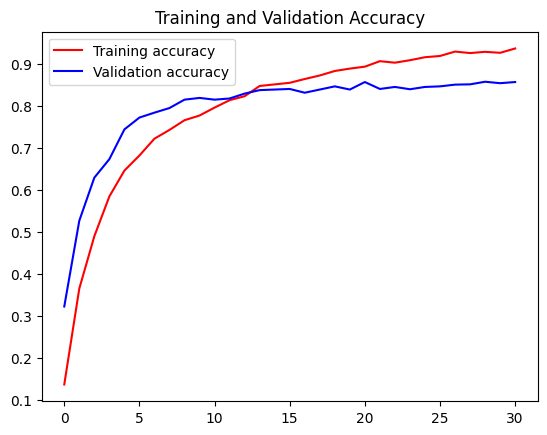

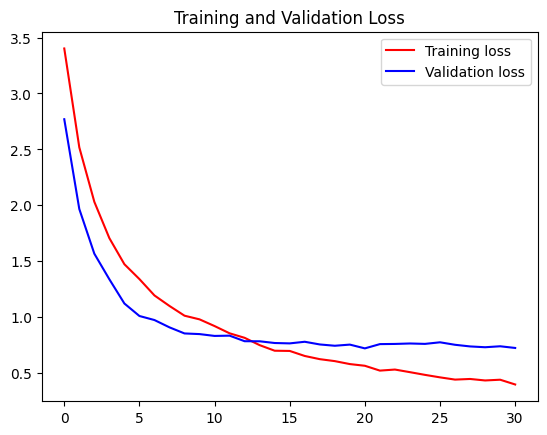

In [ ]:
# Plotting the training and validation accuracy and loss
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

# Plot accuracy
plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and Validation Accuracy')
plt.legend(loc=0)
plt.figure()

# Plot loss
plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and Validation Loss')
plt.legend(loc=0)
plt.show()

# Evaluasi Model

In [ ]:
# Evaluate the model on validation and test sets
val_loss, val_accuracy = model.evaluate(validation_generator)
print(f"Validation Accuracy: {val_accuracy:.2f}%")

46/46 ━━━━━━━━━━━━━━━━━━━━ 17s 373ms/step - accuracy: 0.8605 - loss: 0.7044
Validation Accuracy: 0.86%


In [ ]:
# Predicting on the validation set and printing the classification report
predictions = np.argmax(model.predict(validation_generator), axis=-1)
print(classification_report(validation_generator.classes, predictions, target_names=class_names))

46/46 ━━━━━━━━━━━━━━━━━━━━ 24s 424ms/step
                   precision    recall  f1-score   support

      Ayam Geprek       0.81      0.81      0.81        47
      Ayam Goreng       0.62      0.74      0.67        50
            Bakso       0.82      0.87      0.85        47
       Bika Ambon       0.89      0.96      0.93        26
       Bubur Ayam       0.74      0.87      0.80        46
           Burger       0.98      0.98      0.98        50
     Dadar Gulung       0.95      0.97      0.96        38
        Gado-Gado       0.82      0.84      0.83        50
     Getuk Lindri       0.76      0.81      0.79        27
Ikan Gurame Bakar       0.68      0.87      0.76        46
Ikan Mujair Bakar       0.86      0.73      0.79        51
   Kentang Goreng       0.91      0.96      0.93        50
      Kerak Telor       0.97      0.97      0.97        34
           Klepon       1.00      0.93      0.97        46
        Kue Lapis       0.97      0.91      0.94        33
         Kue 

Saving soto.jpeg to soto (1).jpeg


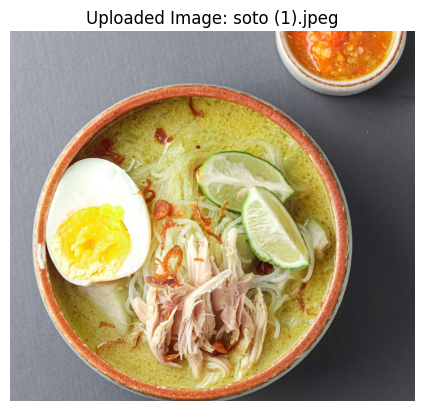

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
Soto
Kalori: 436
Protein: 20.27
Karbohidrat: 23.0
Lemak: 29.18




In [ ]:
# Uploading an image file to classify
uploaded = files.upload()

# Read the nutrition data
data_makanan = pd.read_csv("/content/drive/MyDrive/dataset_food_classification/dataset_gambar/DataNutrisi.csv")

food_id = {0: 'Ayam Geprek', 1: 'Ayam Goreng', 2: 'Bakso', 3: 'Bika Ambon', 4: 'Bubur Ayam', 5: 'Burger', 6: 'Dadar Gulung', 7: 'Gado-Gado', 8: 'Getuk Lindri', 9: 'Ikan Gurame Bakar', 10: 'Ikan Mujair Bakar', 11: 'Kentang Goreng',
           12: 'Kerak Telor', 13: 'Klepon', 14: 'Kue Lapis', 15: 'Kue Sagu', 16: 'Lemper Ayam', 17: 'Martabak Manis', 18: 'Mie Goreng', 19: 'Nasi Gandul', 20: 'Nasi Goreng', 21: 'Nasi Kuning', 22: 'Nasi Padang', 23: 'Pempek',
           24: 'Pizza', 25: 'Rawon', 26: 'Rendang', 27: 'Roti Bakar', 28: 'Sate', 29: 'Sate Usus', 30: 'Serabi', 31: 'Soto', 32: 'Tahu Goreng'}

# Process the uploaded image
for fn in uploaded.keys():
    path = '/content/' + fn
    img = load_img(path)
    plt.imshow(img)
    plt.axis('off')
    plt.title(f"Uploaded Image: {fn}")
    plt.show()

    img = load_img(path, target_size=(224, 224))
    x = img_to_array(img)
    x /= 255  # Normalize the image
    x = np.expand_dims(x, axis=0)
    images = np.vstack([x])

    # Make prediction
    classes = model.predict(images, batch_size=32)

    # Get the predicted class
    predicted_class_index = np.argmax(classes[0])
    predicted_class = food_id[predicted_class_index]

    # Get the nutrition data
    nutrition_data = data_makanan[data_makanan['nama makanan'] == predicted_class]
    if not nutrition_data.empty:
        print(f"{predicted_class}")
        for col in nutrition_data.columns[1:]:
            print(f"{col.capitalize()}: {nutrition_data[col].values[0]}")
        print("\n")
    else:
        print(f"Nutrition data for {predicted_class} not found in the dataset.")

#Convert Model to TFLite

In [ ]:
export_dir = '/content/drive/MyDrive/dataset_food_classification'
tf.saved_model.save(model, export_dir)

In [ ]:
# Convert to TensorFlow Lite format
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()

# Save the TFLite model
with open('food_classification_model.tflite', 'wb') as f:
    f.write(tflite_model)